In [1]:
import os

os.environ["OMP_NUM_THREADS"] = '12'

import torch
import torch.nn
import os.path as osp
import GCL.losses as L
import matplotlib.pyplot as plt
import GCL.augmentors as A
import numpy as np
import scipy.sparse as sp
import torch.nn.functional as F
import math

from torch import nn, tensor
from tqdm import tqdm
from torch.optim import Adam

from scipy.io import loadmat
from dgl.nn.pytorch import GATConv, GraphConv, GATv2Conv

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from munkres import Munkres, print_matrix
from sklearn import metrics
from GCL.models import DualBranchContrast, WithinEmbedContrast
from torch_geometric.utils import degree, to_undirected


In [2]:
import dgl
import dgl.function as fn
import dgl.nn.pytorch as dglnn
from dgl.utils import expand_as_pair
import functional as fun


class GConv(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, num_heads=1):
        super(GConv, self).__init__()
        self.act = nn.ELU()
        self.num_layers = num_layers
        self.norm = nn.BatchNorm1d(num_heads * hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.layers = nn.ModuleList()
        # self.layers.append(
        #     MyGATConv(in_feats=input_dim, out_feats=hidden_dim, allow_zero_in_degree=True, num_heads=num_heads,
        #               residual=False, feat_drop=0.5, attn_drop=0.5)
        # )
        # for _ in range(1, num_layers):
        #     self.layers.append(
        #         MyGATConv(in_feats=num_heads * hidden_dim, out_feats=hidden_dim, allow_zero_in_degree=True,
        #                   num_heads=num_heads, residual=False, feat_drop=0.5, attn_drop=0.5)
        #     )
        self.layers.append(
            GraphConv(in_feats=input_dim, out_feats=hidden_dim, allow_zero_in_degree=True, norm='left')
        )
        for _ in range(1, num_layers):
            self.layers.append(
                GraphConv(in_feats=num_heads * hidden_dim, out_feats=hidden_dim, allow_zero_in_degree=True, norm='left')
            )
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))

    def forward(self, x, graph, edge_weight=None):
        z = x
        attn = None
        for i in range(self.num_layers):
            # z, attn = self.layers[i](graph, z, attn)
            # z = self.layers[i](graph, z, edge_weight=edge_weight)
            # z = self.dropout(z)
            z = self.layers[i](graph, z)
            # z = z.flatten(1)
            z = self.act(z)
            # z = self.norm(z)

        # z = z / (torch.max(torch.norm(z, dim=1, keepdim=True), self.epsilon))
        # z = self.layers[-1](graph, z)
        return z


class Encoder(nn.Module):
    def __init__(self, graph, augmentor, hidden_dim=256, n_clusters=3, num_heads=1, num_layers=3):
        super(Encoder, self).__init__()

        self.encoder = GConv(input_dim=x.size(1), hidden_dim=hidden_dim, num_layers=num_layers, num_heads=num_heads).to(
            device)

        self.augmentor = augmentor
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))

        self.cluster_layer = nn.Parameter(torch.Tensor(n_clusters, num_heads * hidden_dim))
        self.v = 1
        self.device = torch.device('cuda')
        torch.nn.init.xavier_normal_(self.cluster_layer.data)

        self.instance_projector = nn.Sequential(
            nn.Linear(num_heads * hidden_dim, num_heads * hidden_dim),
            nn.ELU(),
            nn.Linear(num_heads * hidden_dim, num_heads * hidden_dim),
        )

        self.cluster_projector = nn.Sequential(
            nn.Linear(num_heads * hidden_dim, num_heads * hidden_dim),
            nn.ELU(),
            nn.Linear(num_heads * hidden_dim, n_clusters),
            nn.Softmax(dim=1)
        )

    def forward(self, x, graph, edge_index, drop_weights, edge_weight=None):
        aug1, aug2 = self.augmentor
        z = self.encoder(x, graph)
        # z = self.decoder(z)

        # x1, edge_index1, edge_weight1 = aug1(x, edge_index, edge_weight, feature_weights)
        edge_index1 = fun.drop_edge_weighted(edge_index, drop_weights, p=0.3, threshold=0.7)
        x1 = fun.drop_feature_weighted_2(x, feature_weights, 0.1)
        graph1 = dgl.graph((edge_index1[0], edge_index1[1]), num_nodes=graph.num_nodes()).to(self.device)
        # graph1.remove_self_loop()
        # graph1.add_self_loop()
        z1 = self.encoder(x1, graph1)

        # x2, edge_index2, edge_weight2 = aug2(x, edge_index, edge_weight)
        edge_index2 = fun.drop_edge_weighted(edge_index, drop_weights, p=0.3, threshold=0.7)
        x2 = fun.drop_feature_weighted_2(x, feature_weights, 0.1)
        graph2 = dgl.graph((edge_index2[0], edge_index2[1]), num_nodes=graph.num_nodes()).to(self.device)
        # graph2.remove_self_loop()
        # graph2.add_self_loop()
        z2 = self.encoder(x2, graph2)

        c1 = self.cluster_projector(z1)
        c2 = self.cluster_projector(z2)

        z1 = self.instance_projector(z1)
        z2 = self.instance_projector(z2)

        return z, z1, z2, c1, c2



In [3]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()



In [4]:

device = torch.device('cuda')
# path = osp.join(osp.pardir, 'datasets', 'DBLP')
#
# mat = loadmat(osp.join(path, 'DBLP4057_GAT_with_idx.mat'))
#
path = osp.join(osp.pardir, 'datasets', 'ACM')

mat = loadmat(osp.join(path, 'ACM3025.mat'))

# path = osp.join(osp.pardir, 'datasets', 'IMDB')
#
# mat = loadmat(osp.join(path, 'imdb5k.mat'))

print(mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'PAP', 'PLP', 'PMP', 'PTP', 'feature', 'label', 'test_idx', 'train_idx', 'val_idx'])


In [5]:
# print(mat['net_APCPA'])

In [6]:
# graph_dict = {}
# # for etype in ['net_APCPA']:
# for etype in ['PAP']:
#     # for etype in ['MDM']:
#     edge_index = []
#     for i in tqdm(range(len(mat[etype]))):
#         for j in range(len(mat[etype])):
#             if mat[etype][i][j] == 1:
#                 edge_index.append([i, j])
#     print(len(edge_index))
#     edge_index = tensor(edge_index, dtype=torch.long).t().contiguous()
#     graph = dgl.graph((edge_index[0], edge_index[1])).to(device)
#     graph.remove_self_loop()
#     graph.add_self_loop()
#
#     edge_index = torch.stack(graph.edges())
#     print(edge_index.size())

def load_graph(graph):
    n, _ = graph.shape

    # idx = np.array([i for i in range(n)], dtype=np.int32)
    # idx_map = {j: i for i, j in enumerate(idx)}
    # edges_unordered = data
    # edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
    #                  dtype=np.int32).reshape(edges_unordered.shape)
    edges = np.array(graph, dtype=np.int32)
    idx = edges.nonzero()  # (row, col)
    data = edges[idx]
    # adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
    #                     shape=(n, n), dtype=np.float32)
    adj = sp.coo_matrix((data, idx), shape=(n, n), dtype=np.float32)
    # build symmetric adjacency matrix
    # adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    # adj = adj + sp.eye(adj.shape[0])
    # adj = normalize(adj)
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    return adj


def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


adj = load_graph(mat['PAP']).to(device)
graph = dgl.graph((adj._indices()[0], adj._indices()[1]), num_nodes=len(mat['PAP'])).to(device)
graph.remove_self_loop()
graph.add_self_loop()
edge_weight = adj._values()
edge_index = torch.stack(graph.edges())
print(graph)
print(adj)

Graph(num_nodes=3025, num_edges=29281,
      ndata_schemes={}
      edata_schemes={})
tensor(indices=tensor([[   0,    0,    0,  ..., 3024, 3024, 3024],
                       [   0,    8,   20,  ..., 2983, 2991, 3024]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       device='cuda:0', size=(3025, 3025), nnz=29281, layout=torch.sparse_coo)


In [7]:
x = tensor(mat['feature'], dtype=torch.float).to(device)
y = torch.argmax(tensor(mat['label']), -1).to(device)

# x = tensor(np.load(osp.join(path, 'acm_feat.npy')), dtype=torch.float).to(device)
# y = tensor(np.load(osp.join(path, 'acm_label.npy'))).to(device)
print(x.size())

torch.Size([3025, 1870])


In [8]:
del mat


model have 809987 paramerters in total


(T): 100%|██████████| 2000/2000 [02:58<00:00, 11.18it/s, loss=14, con_loss=5.64, kl_loss=8.38]  


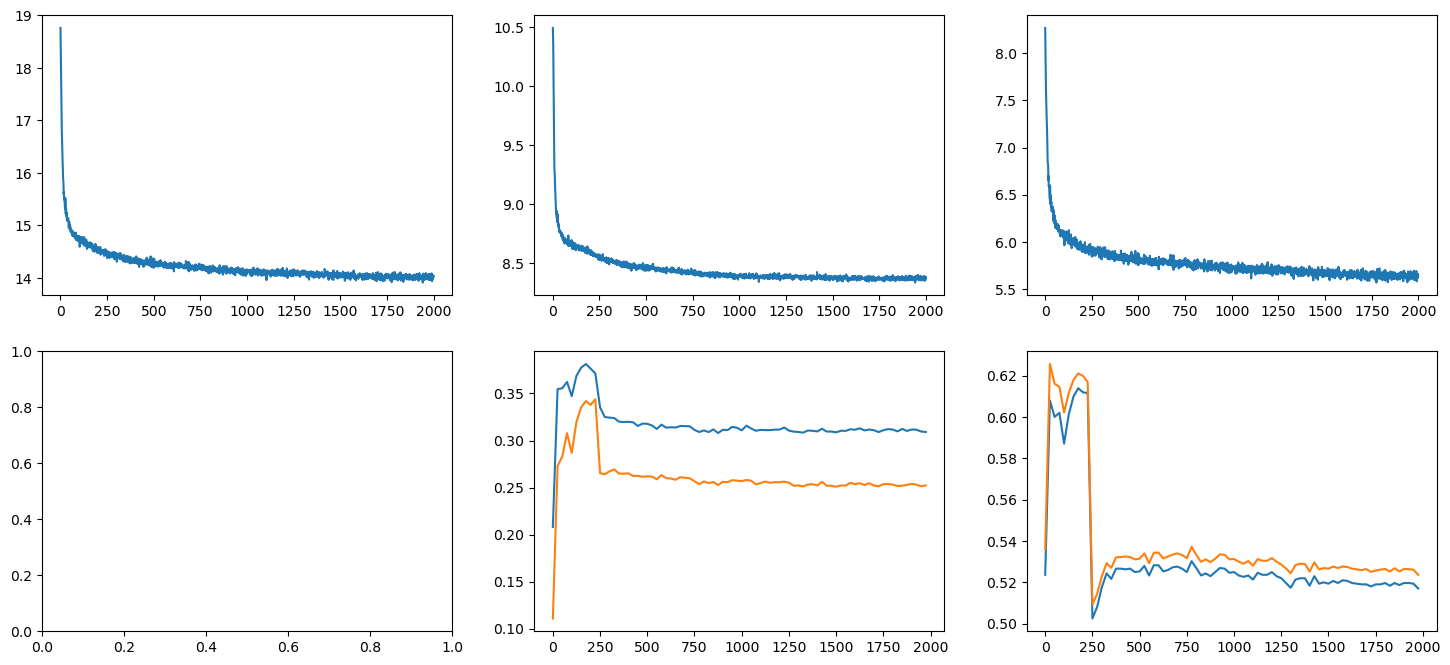

[MAX]ACC:  0.6138842975206612
[MAX]NMI:  0.3813329249292888
[MAX]ARI:  0.34379104097964164
[MAX]F1:  0.6255974953610709


In [24]:


def cluster_acc(y_true, y_pred):
    y_true = y_true - np.min(y_true)

    l1 = list(set(y_true))
    numclass1 = len(l1)

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    ind = 0
    if numclass1 != numclass2:
        for i in l1:
            if i in l2:
                pass
            else:
                y_pred[ind] = i
                ind += 1

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    if numclass1 != numclass2:
        print('error')
        return

    cost = np.zeros((numclass1, numclass2), dtype=int)
    for i, c1 in enumerate(l1):
        mps = [i1 for i1, e1 in enumerate(y_true) if e1 == c1]
        for j, c2 in enumerate(l2):
            mps_d = [i1 for i1 in mps if y_pred[i1] == c2]
            cost[i][j] = len(mps_d)

    # match two clustering results by Munkres algorithm
    m = Munkres()
    cost = cost.__neg__().tolist()
    indexes = m.compute(cost)

    # get the match results
    new_predict = np.zeros(len(y_pred))
    for i, c in enumerate(l1):
        # correponding label in l2:
        c2 = l2[indexes[i][1]]

        # ai is the index with label==c2 in the pred_label list
        ai = [ind for ind, elm in enumerate(y_pred) if elm == c2]
        new_predict[ai] = c

    acc = metrics.accuracy_score(y_true, new_predict)
    f1_macro = metrics.f1_score(y_true, new_predict, average='macro')
    precision_macro = metrics.precision_score(y_true, new_predict, average='macro')
    recall_macro = metrics.recall_score(y_true, new_predict, average='macro')
    f1_micro = metrics.f1_score(y_true, new_predict, average='micro')
    precision_micro = metrics.precision_score(y_true, new_predict, average='micro')
    recall_micro = metrics.recall_score(y_true, new_predict, average='micro')
    return acc, f1_macro


# def train(encoder_model, contrast_model, optimizer, x, graph, edge_index, clu_loss_func=ClusterLoss(class_num=4, temperature=1, device=device)):
def train(encoder_model, contrast_model, optimizer, x, graph, edge_index, drop_weights, feature_weights,
          clu_loss_func=DualBranchContrast(loss=L.InfoNCE(tau=0.2), mode='L2L', intraview_negs=True).to(device)):
    encoder_model.train()
    optimizer.zero_grad()
    _, z1, z2, c1, c2 = encoder_model(x, graph, edge_index, drop_weights)
    con_loss = contrast_model(z1, z2)
    # con_loss = F.mse_loss(torch.matmul(z1, z2.T), torch.eye(z1.size(0)).to('cuda'))

    clu_loss = clu_loss_func(c1.t(), c2.t()) + clu_loss_func(c1, c2)
    # clu_loss = clu_loss_func(c1.t(), c2.t())
    # clu_loss = 0.01 * contrast_model(c1.t(), c2.t())
    # con_loss = 0.01 * con_loss
    loss = (con_loss + clu_loss)

    loss.backward()
    optimizer.step()
    return loss.item(), con_loss.item(), clu_loss.item()


aug1 = A.Compose([A.EdgeRemoving(pe=0.3), A.FeatureDropout(pf=0.3)])
aug2 = A.Compose([A.EdgeRemoving(pe=0.3), A.FeatureDropout(pf=0.3)])
# aug1 = A.Compose([A.MarkovDiffusion()])
# aug2 = A.Compose([A.MarkovDiffusion()])
# encoder_model = Encoder(graph=graph, augmentor=(aug1, aug2), hidden_dim=32, num_heads=4, n_clusters=4, num_layers=2).to(device)
encoder_model = Encoder(graph=graph, augmentor=(aug1, aug2), hidden_dim=256, num_heads=1, n_clusters=3,
                        num_layers=3).to(device)

print("model have {} paramerters in total".format(sum(x.numel() for x in encoder_model.parameters())))

# contrast_model = WithinEmbedContrast(loss=L.BarlowTwins()).to(device)
contrast_model = DualBranchContrast(loss=L.InfoNCE(tau=0.2), mode='L2L', intraview_negs=True).to(device)
# contrast_model = nn.MSELoss()
# contrast_model = WithinEmbedContrast(loss=L.VICReg()).to(device)

# optimizer = Adam(encoder_model.parameters(), lr=5e-4)
optimizer = Adam(encoder_model.parameters(), lr=0.001)
losss = []
kl_losss = []
con_losss = []
nmis = []
aris = []
ratios = []
accs = []
f1s = []
epochs = 2000

kmeans = KMeans(n_clusters=3, n_init=16)

drop_weights = fun.degree_drop_weights(edge_index).to(device)
edge_index_ = to_undirected(edge_index)
node_deg = degree(edge_index_[1])
feature_weights = fun.feature_drop_weights(x, node_c=node_deg).to(device)

with tqdm(total=epochs, desc='(T)') as pbar:
    for epoch in range(epochs):
        encoder_model.train()
        # if epoch % 1 == 0:
        #     # update_interval
        #     _, _, _, tmp_q = encoder_model(x, graph, edge_index)
        #
        #     p = target_distribution(tmp_q.data)

        loss, con_loss, kl_loss = train(encoder_model, contrast_model, optimizer, x, graph, edge_index, drop_weights, feature_weights)
        pbar.set_postfix({'loss': loss, 'con_loss': con_loss, 'kl_loss': kl_loss})
        pbar.update()
        losss.append(loss)
        kl_losss.append(kl_loss)
        con_losss.append(con_loss)
        ratios.append((100 * kl_loss) / loss)

        if epoch % 25 == 0:
            with torch.no_grad():
                encoder_model.eval()
                z, _, _, _, _ = encoder_model(x, graph, edge_index, drop_weights, feature_weights)
            pred = kmeans.fit_predict(z.cpu())
            nmi = normalized_mutual_info_score(pred, y.cpu())
            ari = adjusted_rand_score(pred, y.cpu())
            nmis.append((epoch, nmi))
            aris.append((epoch, ari))

            acc, f1 = cluster_acc(y.cpu().numpy(), pred)

            accs.append((epoch, acc))
            f1s.append((epoch, f1))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes[0][0].plot(range(epochs), losss)
axes[0][1].plot(range(epochs), kl_losss)
axes[0][2].plot(range(epochs), con_losss)
axes[1][1].plot([i[0] for i in nmis], [i[1] for i in nmis])
axes[1][1].plot([i[0] for i in aris], [i[1] for i in aris])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in accs])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in f1s])
plt.show()
print('[MAX]ACC: ', max([i[1] for i in accs]))
print('[MAX]NMI: ', max([i[1] for i in nmis]))
print('[MAX]ARI: ', max([i[1] for i in aris]))
print('[MAX]F1: ', max([i[1] for i in f1s]))
# test_result = test(encoder_model, data)
# print(f'(E): Best test F1Mi={test_result["micro_f1"]:.4f}, F1Ma={test_result["macro_f1"]:.4f}')


D:\Python\anaconda3\envs\black\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
D:\Python\anaconda3\envs\black\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


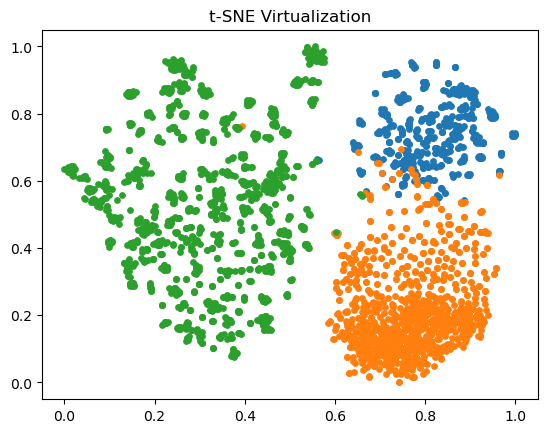

In [25]:
from sklearn import manifold, datasets

tsne = manifold.TSNE(n_components=2, init='pca')

with torch.no_grad():
    encoder_model.eval()
    z, _, _, _, _ = encoder_model(x, graph, edge_index, drop_weights, feature_weights)
    pred = kmeans.fit_predict(z.cpu())
X_tsne = tsne.fit_transform(z.cpu().numpy())
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

d = np.where(pred == 0)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 1)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 2)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 3)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)

plt.title('t-SNE Virtualization')
plt.show()

In [26]:

with torch.no_grad():
    encoder_model.eval()
    z, _, _, qs = encoder_model(x, graph, edge_index)

pred = kmeans.fit_predict(z.cpu())

nmi = normalized_mutual_info_score(pred, y.cpu())
print('[INFO]NMI: ', nmi)

ari = adjusted_rand_score(pred, y.cpu())
print('[INFO]ARI: ', ari)



TypeError: forward() missing 1 required positional argument: 'drop_weights'

In [ ]:

pred = kmeans.fit_predict(x.cpu())

nmi = normalized_mutual_info_score(pred, y.cpu())
print('[INFO]NMI: ', nmi)

ari = adjusted_rand_score(pred, y.cpu())
print('[INFO]ARI: ', ari)

In [ ]:


with torch.no_grad():
    encoder_model.eval()
    z, _, _, _ = encoder_model(x, graph_dict)

pred = kmeans.fit_predict(z.cpu())
acc, f1 = cluster_acc(y.cpu().numpy(), pred)
print(acc, f1)